In [18]:
import sqlite3
import pandas as pd
from contextlib import closing

In [19]:
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    sql_query = pd.read_sql_query("SELECT * from results", connection)
    results = pd.DataFrame(sql_query)

results.head()

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,row_lower_bound,row_upper_bound,description,filtering_type,column_lower_bound,column_upper_bound
0,0.481855,1,1,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
1,0.231139,1,2,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
2,0.399061,1,1,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
3,0.466509,1,2,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8
4,0.440229,1,3,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2,mixed,0.8,0.8


## Aggregate results by Filtering Type

After filtering the results, they are grouped by `window_size` so that metric values with different `experiment_id` are averaged.

In [20]:
import operator
import functools

filtering_types = results['filtering_type'].unique()
NODES_COUNT = 5
SERVICES_COUNT = 5
METRIC_NAME = 'qualitative'
ROW_LOWER_BOUND = 0.2
ROW_UPPER_BOUND = 1
COLUMN_LOWER_BOUND = 0.6
COLUMN_UPPER_BOUND = 0.9
DATASET = 'inmates_enriched_10k'
DESCRIPTION = 'column and row filtering (assigning none to filtered)'

results_filters = [
    lambda df: df['services_count'] == SERVICES_COUNT,
    lambda df: df['nodes_count'] == NODES_COUNT,
    lambda df: df['metric_name'] == METRIC_NAME,
    lambda df: df['row_lower_bound'] == ROW_LOWER_BOUND,
    lambda df: df['row_upper_bound'] == ROW_UPPER_BOUND,
    lambda df: df['column_lower_bound'] == COLUMN_LOWER_BOUND,
    lambda df: df['column_upper_bound'] == COLUMN_UPPER_BOUND,
    lambda df: df['dataset'] == DATASET,
    lambda df: df['description'] == DESCRIPTION
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

In [ ]:
# dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['filtering_type'] == dataset]) \
agg_results_per_filtertype = {}
for filter_type in filtering_types:
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['filtering_type'] == filter_type]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])

    display(dataset_results)
    agg_results_per_filtertype[filter_type] = dataset_results

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for filter_type, dresults in agg_results_per_filtertype.items():
    ax.plot(dresults.index, dresults['metric_value'], label=filter_type)
    plt.xticks(dresults.index)

title_props = {
    'NODES_COUNT': NODES_COUNT,
    'SERVICES_COUNT': SERVICES_COUNT,
    'METRIC_NAME': METRIC_NAME, 
    'ROW_LOWER_BOUND': ROW_LOWER_BOUND, 
    'ROW_UPPER_BOUND': ROW_UPPER_BOUND,
    'COLUMN_LOWER_BOUND': COLUMN_LOWER_BOUND, 
    'COLUMN_UPPER_BOUND': COLUMN_UPPER_BOUND, 
    'DATASET': DATASET,
    'DESCRIPTION': DESCRIPTION
}

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', title_props.items()))
ax.set_title(plot_title)
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend()

plt.savefig('filter_type.svg')
plt.show()

## Aggregate results by Dataset

After filtering the results, they are grouped by `window_size` so that metric values with different `experiment_id` are averaged.

In [21]:
import operator
import functools

tested_datasets = results['dataset'].unique()
NODES_COUNT = 5
SERVICES_COUNT = 5
METRIC_NAME = 'qualitative'
ROW_LOWER_BOUND = 0.2
ROW_UPPER_BOUND = 1
COLUMN_LOWER_BOUND = 0.6
COLUMN_UPPER_BOUND = 0.9
FILTERING_TYPE = 'mixed'
DESCRIPTION = 'column and row filtering (assigning none to filtered)'

results_filters = [
    lambda df: df['services_count'] == SERVICES_COUNT,
    lambda df: df['nodes_count'] == NODES_COUNT,
    lambda df: df['metric_name'] == METRIC_NAME,
    lambda df: df['row_lower_bound'] == ROW_LOWER_BOUND,
    lambda df: df['row_upper_bound'] == ROW_UPPER_BOUND,
    lambda df: df['column_lower_bound'] == COLUMN_LOWER_BOUND,
    lambda df: df['column_upper_bound'] == COLUMN_UPPER_BOUND,
    lambda df: df['filtering_type'] == FILTERING_TYPE,
    lambda df: df['description'] == DESCRIPTION
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

In [22]:
agg_results_per_dataset = {}
for dataset in tested_datasets:
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])

    display(dataset, dataset_results)
    agg_results_per_dataset[dataset] = dataset_results

'inmates_enriched_10k'

,metric_value
window_size,
1,0.596871
2,0.556605
3,0.546470
4,0.542628
5,0.538191


'low_variability_10k'

,metric_value
window_size,
1,0.605410
2,0.573687
3,0.562342
4,0.559290
5,0.556076


'high_variability_10k'

,metric_value
window_size,
1,0.636628
2,0.598145
3,0.588083
4,0.585978
5,0.583174


'red_wine_quality'

,metric_value
window_size,
1,0.594302
2,0.558472
3,0.545307
4,0.539246
5,0.537866


'IBM_HR_Analytics_employee_attrition'

,metric_value
window_size,
1,0.676350
2,0.655974
3,0.633304
4,0.631324
5,0.624180


'avocado'

,metric_value
window_size,
1,0.832555
2,0.832555
3,0.832555
4,0.832555
5,0.832555


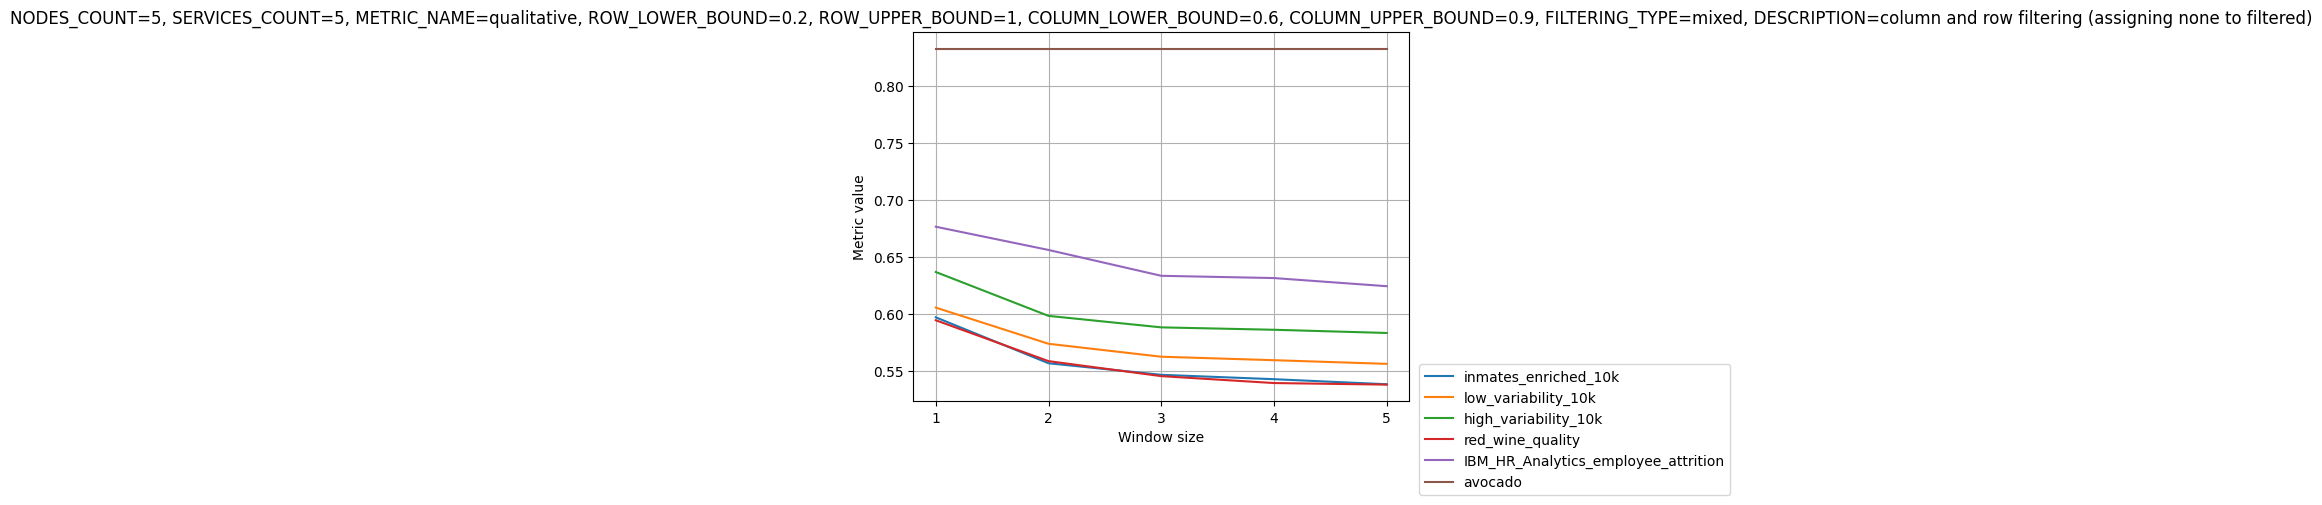

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for dataset, dresults in agg_results_per_dataset.items():
    if len(dresults) == 0:
        continue
    ax.plot(dresults.index, dresults['metric_value'], label=dataset)
    plt.xticks(dresults.index)

title_props = {
    'NODES_COUNT': NODES_COUNT,
    'SERVICES_COUNT': SERVICES_COUNT,
    'METRIC_NAME': METRIC_NAME, 
    'ROW_LOWER_BOUND': ROW_LOWER_BOUND, 
    'ROW_UPPER_BOUND': ROW_UPPER_BOUND,
    'COLUMN_LOWER_BOUND': COLUMN_LOWER_BOUND, 
    'COLUMN_UPPER_BOUND': COLUMN_UPPER_BOUND, 
    'FILTERING_TYPE': FILTERING_TYPE,
    'DESCRIPTION': DESCRIPTION
}

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', title_props.items()))
ax.set_title(plot_title)
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)

plt.savefig('dataset.svg', bbox_inches = "tight")
plt.show()
    

## All experiments by Dataset

Results for the same experiment id are not aggregated but have their own plot

In [12]:
results_per_dataset = {}
for dataset in tested_datasets:
    results_per_dataset[dataset] = {}
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset])
    experiment_ids = dataset_results['experiment_id'].unique()
    for exp_id in experiment_ids:
        exp_id_results = dataset_results[dataset_results['experiment_id'] == exp_id][['window_size', 'metric_value']].drop_duplicates()
        results_per_dataset[dataset][exp_id] = exp_id_results

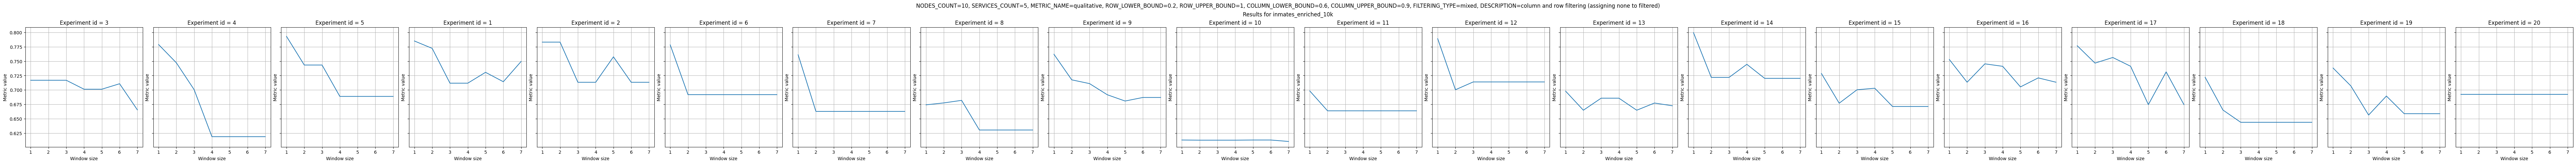

In [17]:
import matplotlib.pyplot as plt

results_per_dataset = {k:v for k, v in results_per_dataset.items() if len(v) > 0}
fig_width = max(len(exp_res) for exp_res in results_per_dataset.values()) * 4

dataset_res_count = len(results_per_dataset)
fig_height = dataset_res_count * 5
fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
fig.suptitle(plot_title)

subfigs = fig.subfigures(nrows=dataset_res_count, ncols=1, squeeze=False)

for i, (dataset, dresults) in enumerate(results_per_dataset.items()):
    subfig = subfigs.item(i)
    subfig.suptitle(f'Results for {dataset}')

    axs = subfig.subplots(1, len(dresults), sharex=True, sharey=True, squeeze=False)
    # plt.figure(figsize=(10, 6))
    for exp_index, (exp_id, exp_id_results) in enumerate(dresults.items()):
        axs[0][exp_index].plot(exp_id_results['window_size'], exp_id_results['metric_value'])#, label=f'Experiment id = {exp_id}')
        axs[0][exp_index].set_xlabel('Window size')
        axs[0][exp_index].set_ylabel('Metric value')
        axs[0][exp_index].set_title(f'Experiment id = {exp_id}')
        axs[0][exp_index].grid(True)
        # axs[i][exp_id].legend()
        plt.xticks(exp_id_results['window_size'])

#fig.tight_layout()
plt.savefig('all_exp.svg', bbox_inches='tight')
plt.show()